In [1]:
# import packages for analysis and modeling
import pandas as pd  # data frame operations

import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns
import plotly as py
import jellyfish

In [2]:
import re

In [3]:
#removes any non digit characters in a dataframe column
def clean_int(df_name, col_name):
    df_name[col_name] = df_name[col_name].str.replace(r'\D', '')

#converts the column type of a data frame
def convert_col(df, col, type_name):
    df[col] = df[col].astype(type_name)
    
#replace NA values with the median of each column to prevent outliers and blank data points
def fill_na_med(df, col):
    df[col] = df[col].fillna(df[col].median())

def value_replace (df, col, cur_value, out_value):
    df.loc[df[col] == cur_value, col] = out_value
    
def summary_NA (df):
    print('-'*35)
    x = df.isna().sum()
    print (x)

## Data Import and Initial Cleaning

In [4]:
coaches_df = pd.read_csv('Coaches9.csv')
coaches_df = coaches_df.drop(columns = ['Coach','AssistantPay','SchoolPay','Bonus','BonusPaid','Buyout'])
print(type(coaches_df))
print(coaches_df.head())

<class 'pandas.core.frame.DataFrame'>
                  School Conference     TotalPay
0              Air Force   Mt. West       885000
1                  Akron        MAC    $412,500 
2                Alabama        SEC  $8,307,000 
3  Alabama at Birmingham      C-USA    $900,000 
4      Appalachian State   Sun Belt    $712,500 


In [5]:
#Liberty University wasn't included in this data set (will probably drop from main automatically 
#when merging occurs)
#https://www.collegegridirons.com/comparisons-by-capacity/

stadium_df = pd.read_csv('Stadium_Size.csv', encoding='cp1252')
stadium_df = stadium_df.drop(columns = 'Stadium')
stadium_df = stadium_df.rename(columns = {'College' : 'School'})
print(stadium_df.head())

       School Conference Capacity  Opened
0    Michigan    Big Ten  107,601    1927
1  Penn State    Big Ten  106,572    1960
2  Ohio State    Big Ten  104,944    1922
3   Texas A&M        SEC  102,733    1904
4   Tennessee        SEC  102,521    1921


In [6]:
#https://www.ncaa.com/standings/football/fbs
#updated as of Jan 27, 2022
winloss_df = pd.read_csv('Win_Loss.csv')
winloss_df = winloss_df.drop(columns = ['HOME', 'AWAY', 'PF','PA','STREAK','CW','CL'])
winloss_df = winloss_df.rename(columns = {'College' : 'School', 'W': 'Win', 'L': 'Loss'})
winloss_df['Win_Percentage'] = winloss_df['Win']/(winloss_df['Win'] + winloss_df['Loss'])
print(winloss_df.head())
print(winloss_df.dtypes)

          School  Win  Loss Conference  Win_Percentage
0     Cincinnati   13     1        AAC        0.928571
1        Houston   12     2        AAC        0.857143
2            UCF    9     4        AAC        0.692308
3  East Carolina    7     5        AAC        0.583333
4          Tulsa    7     6        AAC        0.538462
School             object
Win                 int64
Loss                int64
Conference         object
Win_Percentage    float64
dtype: object


In [7]:
grad_df = pd.read_csv('Grad_Rate.csv')
grad_df = grad_df.drop(columns = ['Cohort Year', 'Sport', 'State'])
print(grad_df.head())
print(grad_df.dtypes)

                         School                   Conference  GSR   FGR
0  Abilene Christian University         Southland Conference   75  51.0
1           University of Akron      Mid-American Conference   79  76.0
2        Alabama A&M University  Southwestern Athletic Conf.   62  54.0
3      Alabama State University  Southwestern Athletic Conf.   71  42.0
4         University of Alabama      Southeastern Conference   86  65.0
School         object
Conference     object
GSR             int64
FGR           float64
dtype: object


In [8]:
#cleaning columns that contain numbers free of any non-digit characters
clean_int(coaches_df,'TotalPay')
clean_int(stadium_df,'Capacity')

In [9]:
#replacing any empty values with NaN
coaches_df = coaches_df.replace('', np.nan)
stadium_df = stadium_df.replace('',np.nan)
winloss_df = winloss_df.replace('',np.nan)
grad_df = grad_df.replace('',np.nan)

In [10]:
print('Obtaining the number of NA values in each dataframe')
summary_NA(coaches_df)
summary_NA(stadium_df)
summary_NA(winloss_df)
summary_NA(grad_df)

Obtaining the number of NA values in each dataframe
-----------------------------------
School        0
Conference    0
TotalPay      4
dtype: int64
-----------------------------------
School        0
Conference    0
Capacity      0
Opened        0
dtype: int64
-----------------------------------
School            0
Win               0
Loss              0
Conference        0
Win_Percentage    0
dtype: int64
-----------------------------------
School         0
Conference     0
GSR            0
FGR           17
dtype: int64


In [11]:
coach_blankpayIndex = coaches_df[coaches_df['TotalPay'].isna()].index.tolist()
print('Schools we are removing due to missing information in the Coaches data set')
print('-' * 60)

#Either loops here would get the job done
#for name in coach_blankpayIndex:
    #print(coaches_df['School'].iloc[name])

for x in coach_blankpayIndex:
    print(coaches_df.loc[x,'School'])

coaches_df = coaches_df.drop(labels = coach_blankpayIndex)

#resetting the index numbers just in case we need to use it again later for merging
coaches_df = coaches_df.reset_index(drop = True)

Schools we are removing due to missing information in the Coaches data set
------------------------------------------------------------
Baylor
Brigham Young
Rice
Southern Methodist


In [12]:
grad_blankpayIndex = grad_df[grad_df['FGR'].isna()].index.tolist()
print('Schools we are removing due to missing information in the Grad data set')
print('-' * 60)

for x in grad_blankpayIndex:
    print(grad_df.loc[x,'School'])

grad_df = grad_df.drop(labels = grad_blankpayIndex)

#resetting the index numbers just in case we need to use it again later for merging
grad_df = grad_df.reset_index(drop = True)

Schools we are removing due to missing information in the Grad data set
------------------------------------------------------------
Brown University
Butler University
Columbia University-Barnard College
Cornell University
Dartmouth College
Davidson College
University of Dayton
East Tennessee State University
Harvard University
Morehead State University
University of San Diego
Stetson University
U.S. Air Force Academy
U.S. Military Academy
U.S. Naval Academy
Valparaiso University
Yale University


In [13]:
convert_col(coaches_df, 'TotalPay', int)
convert_col(stadium_df, 'Capacity', int)
'''
convert_col(coaches_df, 'Conference', 'category')
convert_col(stadium_df, 'Conference', 'category')
convert_col(winloss_df, 'Conference', 'category')
convert_col(grad_df, 'Conference', 'category')
'''
print(coaches_df.dtypes)
print('-'*20)
print(stadium_df.dtypes)
print('-'*20)
print(winloss_df.dtypes)
print('-'*20)
print(grad_df.dtypes)
print('-'*20)

School        object
Conference    object
TotalPay       int32
dtype: object
--------------------
School        object
Conference    object
Capacity       int32
Opened         int64
dtype: object
--------------------
School             object
Win                 int64
Loss                int64
Conference         object
Win_Percentage    float64
dtype: object
--------------------
School         object
Conference     object
GSR             int64
FGR           float64
dtype: object
--------------------


In [14]:
#Checking the conference names

print("Coaches <-- THIS IS THE MAIN DATA SOURCE WE WILL BE CHANGING THE CONFERENCE NAMES INTO")
print(coaches_df['Conference'].value_counts(sort = False))
print('-' *40)
print("Stadium")
print(stadium_df['Conference'].value_counts(sort = False))
print('-' *40)
print("WinLoss")
print(winloss_df['Conference'].value_counts(sort = False))
print('-' *40)
print("Grad")
print(grad_df['Conference'].value_counts(sort = False))
print('-' *40)


Coaches <-- THIS IS THE MAIN DATA SOURCE WE WILL BE CHANGING THE CONFERENCE NAMES INTO
SEC         14
AAC         10
Ind.         5
Mt. West    12
MAC         12
Big 12       9
Big Ten     14
ACC         14
Sun Belt    10
Pac-12      12
C-USA       13
Name: Conference, dtype: int64
----------------------------------------
Stadium
AAC              12
SEC              14
Mountain West    12
MAC              13
Pac 12           12
Big Ten          14
Big 12           10
ACC              14
Independent       4
CUSA             14
Sun Belt         12
Name: Conference, dtype: int64
----------------------------------------
WinLoss
Ind.         7
AAC         11
Mt. West    12
MAC         12
SEC         14
Big Ten     14
Big 12      10
ACC         14
Sun Belt    10
Pac-12      12
C-USA       14
Name: Conference, dtype: int64
----------------------------------------
Grad
Patriot League                          7
Mountain West Conference               11
Big 12 Conference                      10


Renaming the conference names to match the ones in coaches_df

In [15]:
value_replace(stadium_df, 'Conference', 'CUSA', 'C-USA')
value_replace(stadium_df, 'Conference', 'Pac 12', 'Pac-12')
value_replace(stadium_df, 'Conference', 'Mountain West', 'Mt. West')
value_replace(stadium_df, 'Conference', 'Independent', 'Ind.')

In [16]:
value_replace(grad_df, 'Conference', 'Southeastern Conference', 'SEC')
value_replace(grad_df, 'Conference', 'Independent', 'Ind.')
value_replace(grad_df, 'Conference', 'Sun Belt Conference', 'Sun Belt')
value_replace(grad_df, 'Conference', 'Mountain West Conference', 'Mt. West')
value_replace(grad_df, 'Conference', 'Pac-12 Conference', 'Pac-12')
value_replace(grad_df, 'Conference', 'Big 12 Conference', 'Big 12')
value_replace(grad_df, 'Conference', 'Mid-American Conference', 'MAC')
value_replace(grad_df, 'Conference', 'American Athletic Conference', 'AAC')
value_replace(grad_df, 'Conference', 'Conference USA', 'C-USA')
value_replace(grad_df, 'Conference', 'Big Ten Conference', 'Big Ten')
value_replace(grad_df, 'Conference', 'Atlantic Coast Conference', 'ACC')

In [17]:
conference_list = ['AAC','ACC','Big 12','Big Ten','C-USA','Ind.','MAC','Mt. West','Pac-12','SEC','Sun Belt']

In [18]:
#removing all other conferences from the grad_df so only the ones listed in coaches_df would remain
grad_df = grad_df[grad_df.Conference.isin(conference_list)]

In [19]:
print(coaches_df.shape)
print(stadium_df.shape)
print(winloss_df.shape)
print(grad_df.shape)

(125, 3)
(131, 4)
(130, 5)
(130, 4)


In [20]:
print(coaches_df.head())
print(stadium_df.head())

                  School Conference  TotalPay
0              Air Force   Mt. West    885000
1                  Akron        MAC    412500
2                Alabama        SEC   8307000
3  Alabama at Birmingham      C-USA    900000
4      Appalachian State   Sun Belt    712500
       School Conference  Capacity  Opened
0    Michigan    Big Ten    107601    1927
1  Penn State    Big Ten    106572    1960
2  Ohio State    Big Ten    104944    1922
3   Texas A&M        SEC    102733    1904
4   Tennessee        SEC    102521    1921


## Data Merging

Merging the data frames together with the coaches_df as the base.

Fuzzy Matching was implemented here to compare the Schools and Conference on both dataframes and then merge them on those fields.

In [21]:
import fuzzymatcher

In [22]:
#https://stackoverflow.com/questions/13636848/is-it-possible-to-do-fuzzy-match-merge-with-python-pandas/56315491#56315491
left_on = ['School', 'Conference']

# Columns to match on from df_right
right_on = ['School', 'Conference']

next_df = fuzzymatcher.fuzzy_left_join(coaches_df, stadium_df, left_on, right_on)


Anything with a negative best_match_score was removed because it most likely didn't match up. There could be instances where some type 1 error was made and a matched school was removed. However, since the columns weren't labelled the same across all dataframes then that's an outcome that needs to be accepted.

The following merging and cleaning method is done to mitigiate this error if possible, and keep as many rows as we can.

In [23]:
next_df = next_df[next_df['best_match_score'] > 0]
next_df_edit = next_df[next_df.duplicated(['School_right'],keep=False)]

In [24]:
next_df_edit

,best_match_score,__id_left,__id_right,School_left,Conference_left,TotalPay,School_right,Conference_right,Capacity,Opened
32,0.253469,16_left,37_right,California,Pac-12,1500000,California,Pac-12,62717,1923
82,0.148376,59_left,120_right,Miami (Ohio),MAC,524826,Ohio,MAC,24000,1929
94,0.358871,69_left,110_right,Nevada,Mt. West,500000,Nevada,Mt. West,29993,1966
95,0.205469,70_left,110_right,Nevada-Las Vegas,Mt. West,600000,Nevada,Mt. West,29993,1966
122,0.388291,73_left,36_right,North Carolina,ACC,2575000,North Carolina,ACC,62980,1927
123,0.358555,74_left,36_right,North Carolina State,ACC,3000000,North Carolina,ACC,62980,1927
149,0.467777,75_left,97_right,North Texas,C-USA,1425000,North Texas,C-USA,30850,2011
153,0.214676,79_left,120_right,Ohio,MAC,580331,Ohio,MAC,24000,1929
171,0.187169,95_left,37_right,Southern California,Pac-12,2625965,California,Pac-12,62717,1923
200,0.196837,100_left,7_right,Texas,Big 12,5500000,Texas,Big 12,100119,1924


In [25]:
next_df = next_df.drop([82,95,123,171,203,207,208])
next_df = next_df.drop(columns = ['Conference_right','School_right','best_match_score','__id_left','__id_right'])
next_df = next_df.rename(columns = {'School_left' :'School', 'Conference_left': 'Conference'})
print(next_df)

                School Conference  TotalPay  Capacity  Opened
0            Air Force   Mt. West    885000     52237    1962
1                Akron        MAC    412500     30000    2009
2              Alabama        SEC   8307000    101821    1929
19   Appalachian State   Sun Belt    712500     24150    1962
20             Arizona     Pac-12   2000000     56037    1928
..                 ...        ...       ...       ...     ...
224      West Virginia     Big 12   3617500     60000    1980
225   Western Kentucky      C-USA    805850     22113    1968
226   Western Michigan        MAC    800000     30200    1939
227          Wisconsin    Big Ten   3750000     80321    1917
228            Wyoming   Mt. West   1412000     29181    1950

[115 rows x 5 columns]


In [26]:
left_on = ['School', 'Conference']
right_on = ['School', 'Conference']
next_df2 = fuzzymatcher.fuzzy_left_join(next_df, winloss_df, left_on, right_on)

In [27]:
next_df2 = next_df2[next_df2['best_match_score'] > 0]
next_df_edit2 = next_df2[next_df2.duplicated(['School_right'],keep=False)]

In [28]:
next_df_edit2

,best_match_score,__id_left,__id_right,School_left,Conference_left,TotalPay,Capacity,Opened,School_right,Win,Loss,Conference_right,Win_Percentage
3,0.156611,3_left,121_right,Appalachian State,Sun Belt,712500,24150,1962,App State,10,4,Sun Belt,0.714286
4,0.232355,4_left,105_right,Arizona,Pac-12,2000000,56037,1928,Arizona,1,11,Pac-12,0.083333
6,0.166205,5_left,105_right,Arizona State,Pac-12,2000000,56232,1958,Arizona,1,11,Pac-12,0.083333
19,0.165393,7_left,121_right,Arkansas State,Sun Belt,825000,30964,2002,App State,10,4,Sun Belt,0.714286
169,0.365874,39_left,43_right,Illinois,Big Ten,5000000,60670,1923,Illinois,5,7,Big Ten,0.416667
182,0.222321,43_left,34_right,Kansas,Big 12,1701109,50071,1921,Kansas,2,10,Big 12,0.166667
184,0.156170,44_left,34_right,Kansas State,Big 12,3500000,50000,1968,Kansas,2,10,Big 12,0.166667
208,0.301798,48_left,120_right,Louisiana-Lafayette,Sun Belt,850000,31000,1971,Louisiana,13,1,Sun Belt,0.928571
209,0.301798,49_left,120_right,Louisiana-Monroe,Sun Belt,390000,30427,1978,Louisiana,13,1,Sun Belt,0.928571
229,0.335771,56_left,35_right,Michigan,Big Ten,7504000,107601,1927,Michigan,12,2,Big Ten,0.857143


In [29]:
next_df2 = next_df2.drop([6,19,184,208,209,231,260,289,321,334,424])
next_df2 = next_df2.drop(columns = ['Conference_right','School_right','best_match_score','__id_left','__id_right'])
next_df2 = next_df2.rename(columns = {'School_left' :'School', 'Conference_left': 'Conference'})
print(next_df2)

                School Conference  TotalPay  Capacity  Opened  Win  Loss  \
0            Air Force   Mt. West    885000     52237    1962   10     3   
1                Akron        MAC    412500     30000    2009    2    10   
2              Alabama        SEC   8307000    101821    1929   13     2   
3    Appalachian State   Sun Belt    712500     24150    1962   10     4   
4              Arizona     Pac-12   2000000     56037    1928    1    11   
..                 ...        ...       ...       ...     ...  ...   ...   
436      West Virginia     Big 12   3617500     60000    1980    6     7   
437   Western Kentucky      C-USA    805850     22113    1968    9     5   
438   Western Michigan        MAC    800000     30200    1939    8     5   
450          Wisconsin    Big Ten   3750000     80321    1917    9     4   
451            Wyoming   Mt. West   1412000     29181    1950    7     6   

     Win_Percentage  
0          0.769231  
1          0.166667  
2          0.866667  

In [30]:
left_on = ['School', 'Conference']
right_on = ['School', 'Conference']
next_df3 = fuzzymatcher.fuzzy_left_join(next_df2, grad_df, left_on, right_on)

In [31]:
next_df3 = next_df3[next_df3['best_match_score'] > 0]
next_df_edit3 = next_df3[next_df3.duplicated(['School_right'],keep=False)]

In [32]:
next_df_edit3

,best_match_score,__id_left,__id_right,School_left,Conference_left,TotalPay,Capacity,Opened,Win,Loss,Win_Percentage,School_right,Conference_right,GSR,FGR
146,0.108831,81_left,106_right,Texas,Big 12,5500000,100119,1924,5,7,0.416667,Texas Tech University,Big 12,76,52.0
151,0.416456,84_left,106_right,Texas Tech,Big 12,3703975,60862,1947,7,6,0.538462,Texas Tech University,Big 12,76,52.0
181,0.242603,93_left,118_right,Virginia,ACC,3550000,61500,1931,6,6,0.500000,University of Virginia,ACC,86,71.0
183,0.164133,94_left,118_right,Virginia Tech,ACC,4000000,66233,1965,6,7,0.461538,University of Virginia,ACC,86,71.0


In [33]:
next_df3 = next_df3.drop([146,183])
next_df3 = next_df3.drop(columns = ['Conference_right','School_right','best_match_score','__id_left','__id_right'])
next_df3 = next_df3.rename(columns = {'School_left' :'School', 'Conference_left': 'Conference'})
print(next_df3)

                School Conference  TotalPay  Capacity  Opened  Win  Loss  \
12               Akron        MAC    412500     30000    2009    2    10   
13             Alabama        SEC   8307000    101821    1929   13     2   
14   Appalachian State   Sun Belt    712500     24150    1962   10     4   
15             Arizona     Pac-12   2000000     56037    1928    1    11   
17            Arkansas        SEC   3500000     72000    1938    9     4   
..                 ...        ...       ...       ...     ...  ...   ...   
188      West Virginia     Big 12   3617500     60000    1980    6     7   
189   Western Kentucky      C-USA    805850     22113    1968    9     5   
190   Western Michigan        MAC    800000     30200    1939    8     5   
191          Wisconsin    Big Ten   3750000     80321    1917    9     4   
192            Wyoming   Mt. West   1412000     29181    1950    7     6   

     Win_Percentage  GSR   FGR  
12         0.166667   79  76.0  
13         0.866667  

In [34]:
#our merged data frame exists now
merged_df = next_df3

## Final Data Cleaning After Merge

In [35]:
#Grabbing all the removed schools from the original dataframe
remaining_school_list = merged_df['School'].tolist()
removed_schools = coaches_df[~coaches_df.School.isin(remaining_school_list)]['School'].tolist()
#including the 4 schools removed from the data cleaning initially
removed_schools.append('Baylor')
removed_schools.append('Brigham Young')
removed_schools.append('Rice')
removed_schools.append('Southern Methodist')

print('Schools removed due to inconsistency in naming and/or missing data :')
print('-'*40)
counter = 0
for x in removed_schools:
    counter += 1
    print(counter,x)
    

Schools removed due to inconsistency in naming and/or missing data :
----------------------------------------
1 Air Force
2 Alabama at Birmingham
3 Arizona State
4 Arkansas State
5 Army
6 Buffalo
7 Connecticut
8 Florida International
9 Kansas State
10 Liberty
11 Louisiana-Lafayette
12 Louisiana-Monroe
13 LSU
14 Massachusetts
15 Miami (Ohio)
16 Michigan State
17 Mississippi
18 Navy
19 Nevada-Las Vegas
20 North Carolina State
21 Northern Illinois
22 Oklahoma State
23 Oregon State
24 Southern California
25 Texas
26 Texas Christian
27 Texas-El Paso
28 Texas-San Antonio
29 UCLA
30 Virginia Tech
31 Washington State
32 Baylor
33 Brigham Young
34 Rice
35 Southern Methodist


In [36]:
#final step of removing the Wins and Losses since Win percentage has been calculated
merged_df = merged_df.drop(columns = ['Win','Loss'])
print(merged_df)

                School Conference  TotalPay  Capacity  Opened  Win_Percentage  \
12               Akron        MAC    412500     30000    2009        0.166667   
13             Alabama        SEC   8307000    101821    1929        0.866667   
14   Appalachian State   Sun Belt    712500     24150    1962        0.714286   
15             Arizona     Pac-12   2000000     56037    1928        0.083333   
17            Arkansas        SEC   3500000     72000    1938        0.692308   
..                 ...        ...       ...       ...     ...             ...   
188      West Virginia     Big 12   3617500     60000    1980        0.461538   
189   Western Kentucky      C-USA    805850     22113    1968        0.642857   
190   Western Michigan        MAC    800000     30200    1939        0.615385   
191          Wisconsin    Big Ten   3750000     80321    1917        0.692308   
192            Wyoming   Mt. West   1412000     29181    1950        0.538462   

     GSR   FGR  
12    79  

## Data Visualization 

In [37]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

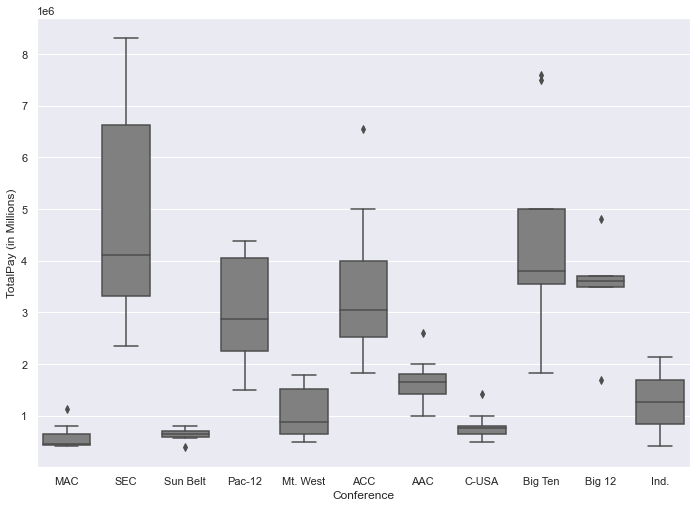

In [38]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="Conference", y="TotalPay", data=merged_df, color = "gray").set(ylabel = 'TotalPay (in Millions)')
plt.show()

The Power 5 variable is created to provide a clearer picture here and also to provide a better predictor variable since  there aren't that many obervations for running the model in the other conferences.

In [39]:
power5_list = ['SEC', 'Pac-12', 'ACC', 'Big Ten', 'Big 12']
merged_df['power5'] = 0
merged_df['power5'] = np.where((merged_df.Conference.isin(power5_list)),1,merged_df.power5)
print(merged_df)


                School Conference  TotalPay  Capacity  Opened  Win_Percentage  \
12               Akron        MAC    412500     30000    2009        0.166667   
13             Alabama        SEC   8307000    101821    1929        0.866667   
14   Appalachian State   Sun Belt    712500     24150    1962        0.714286   
15             Arizona     Pac-12   2000000     56037    1928        0.083333   
17            Arkansas        SEC   3500000     72000    1938        0.692308   
..                 ...        ...       ...       ...     ...             ...   
188      West Virginia     Big 12   3617500     60000    1980        0.461538   
189   Western Kentucky      C-USA    805850     22113    1968        0.642857   
190   Western Michigan        MAC    800000     30200    1939        0.615385   
191          Wisconsin    Big Ten   3750000     80321    1917        0.692308   
192            Wyoming   Mt. West   1412000     29181    1950        0.538462   

     GSR   FGR  power5  
12

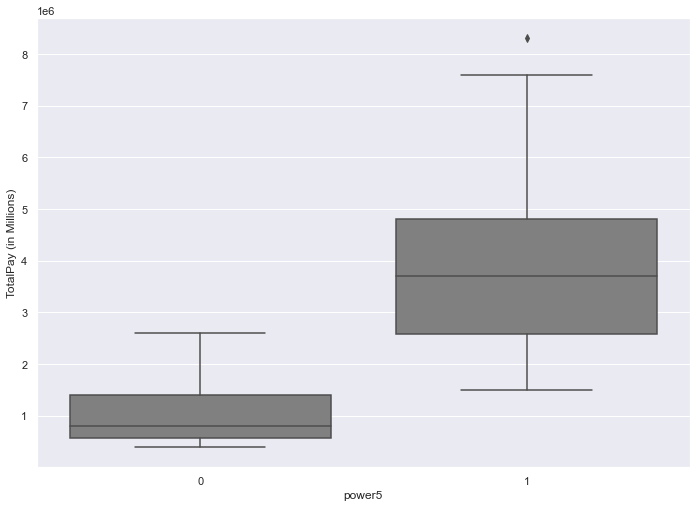

In [40]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="power5", y="TotalPay", data=merged_df, color = "gray").set(ylabel = 'TotalPay (in Millions)')
plt.show()

In [41]:
#finding out what the outlier is
merged_df[merged_df['TotalPay'] > 8000000]

,School,Conference,TotalPay,Capacity,Opened,Win_Percentage,GSR,FGR,power5
13,Alabama,SEC,8307000,101821,1929,0.866667,86,65.0,1


In [42]:
#capturing all the outlier schools
outlier_school = []

In [43]:
outlier_school.append(merged_df.loc[13,'School'])

In [44]:
#removing those outliers
merged_df = merged_df[~merged_df.School.isin(outlier_school)]

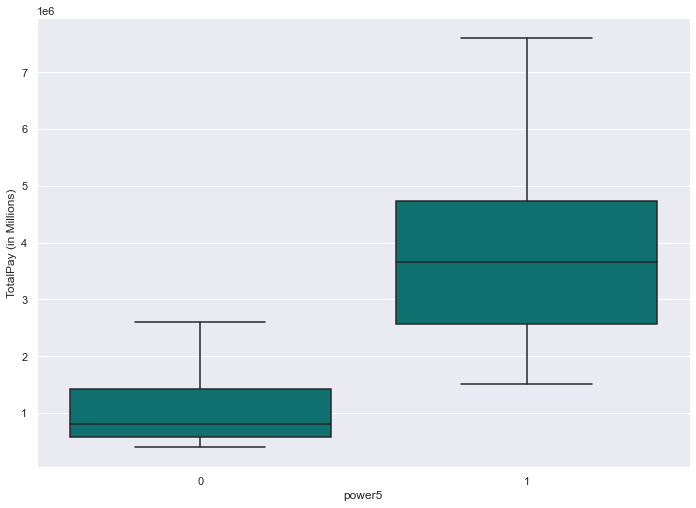

In [45]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="power5", y="TotalPay", data=merged_df, color = "teal").set(ylabel = 'TotalPay (in Millions)')
plt.show()

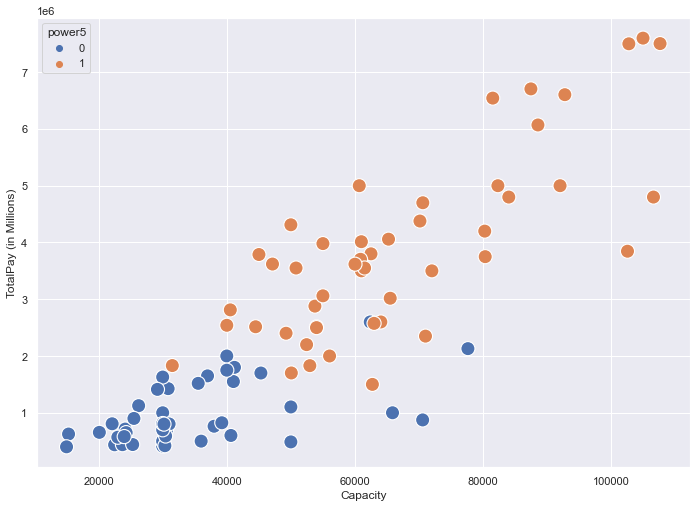

In [46]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data = merged_df, x='Capacity', y='TotalPay', hue = 'power5', s = 200).set(ylabel = 'TotalPay (in Millions)')
#plt.legend(markerscale = 2)
plt.show()

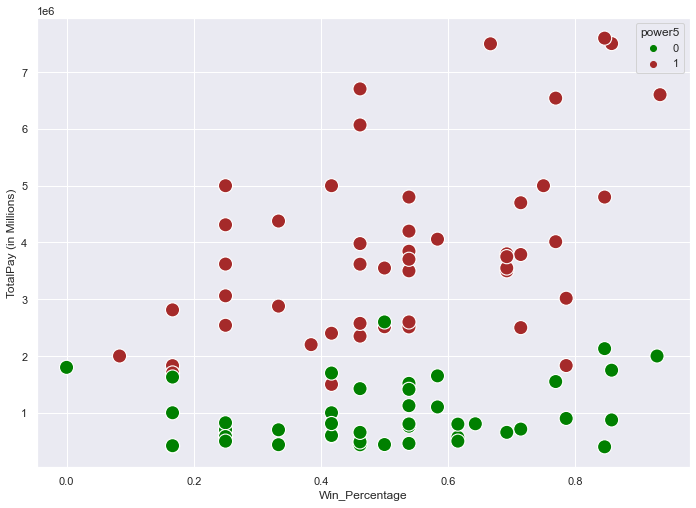

In [47]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data = merged_df, x='Win_Percentage', y='TotalPay', hue = 'power5', s = 200,
               palette = ['green', 'brown']).set(ylabel = 'TotalPay (in Millions)')
#plt.legend(markerscale = 2)
plt.show()

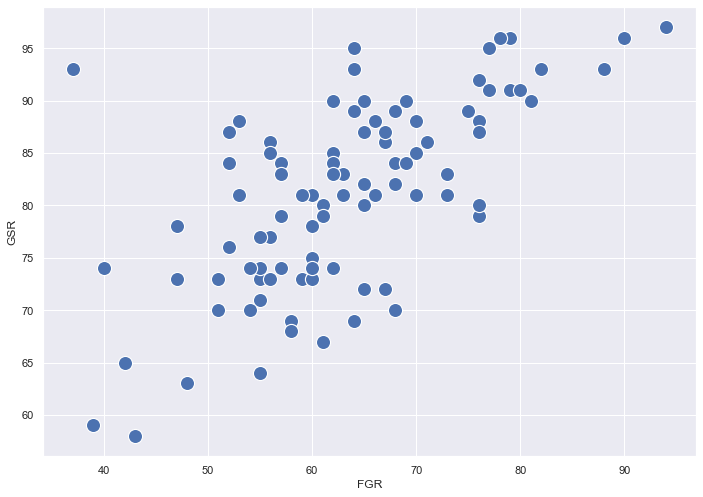

In [48]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data = merged_df, x='FGR', y='GSR', s = 200,
               palette = ['green', 'brown'])
#plt.legend(markerscale = 2)
plt.show()

## Linear Regression Modeling

In [49]:
#obtained  code from class async work
# employ training-and-test regimen for model validation
print('Model 1')
print('-' * 78)
merged_df1 = merged_df
np.random.seed(123)
merged_df1['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(merged_df))
merged_df1_train = merged_df1[merged_df1['runiform'] >= 0.33]
merged_df1_test = merged_df1[merged_df1['runiform'] < 0.33]

# specify a simple model with all the models
my_model1 = str('TotalPay ~ power5 + Capacity + Opened + FGR + GSR')

# fit the model to the training set
train_model_fit1 = smf.ols(my_model1, data = merged_df1_train).fit()
# summary of model fit to the training set
print(train_model_fit1.summary())
# training set predictions from the model fit to the training set
merged_df1_train['predict_pay'] = train_model_fit1.fittedvalues

# test set predictions from the model fit to the training set
merged_df1_test['predict_pay'] = train_model_fit1.predict(merged_df1_test)

Model 1
------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     57.62
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           5.14e-22
Time:                        17:51:45   Log-Likelihood:                -1024.3
No. Observations:                  68   AIC:                             2061.
Df Residuals:                      62   BIC:                             2074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

<ipython-input-49-357a3c77d65b>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-49-357a3c77d65b>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
#obtained  code from class async work
# employ training-and-test regimen for model validation
print('Model 2')
print('-' * 78)
merged_df2 = merged_df
np.random.seed(123)
merged_df2['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(merged_df))
merged_df2_train = merged_df2[merged_df2['runiform'] >= 0.33]
merged_df2_test = merged_df2[merged_df2['runiform'] < 0.33]

# specify a simple model with all the models
my_model2 = str('TotalPay ~ power5 + Capacity')

# fit the model to the training set
train_model_fit2 = smf.ols(my_model2, data = merged_df2_train).fit()
# summary of model fit to the training set
print(train_model_fit2.summary())
# training set predictions from the model fit to the training set
merged_df2_train['predict_pay'] = train_model_fit2.fittedvalues

# test set predictions from the model fit to the training set
merged_df2_test['predict_pay'] = train_model_fit2.predict(merged_df2_test)

Model 2
------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     146.9
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           7.69e-25
Time:                        17:51:45   Log-Likelihood:                -1025.1
No. Observations:                  68   AIC:                             2056.
Df Residuals:                      65   BIC:                             2063.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

<ipython-input-50-bce2d03300cb>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-50-bce2d03300cb>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
#obtained  code from class async work
# employ training-and-test regimen for model validation
print('Model 3')
print('-' * 78)
merged_df3 = merged_df
np.random.seed(123)
merged_df3['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(merged_df))
merged_df3_train = merged_df3[merged_df3['runiform'] >= 0.33]
merged_df3_test = merged_df3[merged_df3['runiform'] < 0.33]

# specify a simple model with all the models
my_model3 = str('TotalPay ~ Conference + Capacity')

# fit the model to the training set
train_model_fit3 = smf.ols(my_model3, data = merged_df3_train).fit()
# summary of model fit to the training set
print(train_model_fit3.summary())
# training set predictions from the model fit to the training set
merged_df3_train['predict_pay'] = train_model_fit3.fittedvalues

# test set predictions from the model fit to the training set
merged_df3_test['predict_pay'] = train_model_fit3.predict(merged_df3_test)

Model 3
------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     24.41
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           1.80e-17
Time:                        17:51:45   Log-Likelihood:                -1023.5
No. Observations:                  68   AIC:                             2071.
Df Residuals:                      56   BIC:                             2098.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

<ipython-input-51-03b46ccaa945>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-51-03b46ccaa945>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Going create some additional models that's some variation of the Model 3 for obtaining a salary range for a Syracuse University Coach because those variables seem to be signficiant

## TotalPay Prediction

Going to test some additional models out for obtaining a salary range for a Syracuse University Coach 

In [52]:
syr_coach = pd.DataFrame({
    'School':['Syracuse','Syracuse','Syracuse'],
    'power5':[0,1,1],
    'Conference': ['AAC','ACC','Big Ten'],
    'Capacity': [49520,49520,49520]
})
print(syr_coach)

     School  power5 Conference  Capacity
0  Syracuse       0        AAC     49520
1  Syracuse       1        ACC     49520
2  Syracuse       1    Big Ten     49520


In [53]:
#obtaining a range for coaches
syr_coach['predicted_pay1'] = train_model_fit2.predict(syr_coach)
print(syr_coach)

     School  power5 Conference  Capacity  predicted_pay1
0  Syracuse       0        AAC     49520    1.701585e+06
1  Syracuse       1        ACC     49520    3.084650e+06
2  Syracuse       1    Big Ten     49520    3.084650e+06


In [54]:
syr_coach['predicted_pay2'] = train_model_fit3.predict(syr_coach)
print(syr_coach)

     School  power5 Conference  Capacity  predicted_pay1  predicted_pay2
0  Syracuse       0        AAC     49520    1.701585e+06    1.751476e+06
1  Syracuse       1        ACC     49520    3.084650e+06    3.002165e+06
2  Syracuse       1    Big Ten     49520    3.084650e+06    3.203270e+06


## Questions

<b>What is the recommended salary for the Syracuse football coach? </b>

The recommended salary range would be <b>3,002,165 to 3,084,650</b>

______________________________________________________________

<b>What would his salary be if we were still in the Big East? What if we went to the Big Ten? </b>

Big East (aka AAC): <b>1,701,585 to 1,751,476</b>

Big Ten: <b>3,084,650 to 3,203,270</b>

______________________________________________________________


<b>What schools did we drop from our data and why?</b> 

In [55]:
#Grabbing all the removed schools from the original dataframe
remaining_school_list = merged_df['School'].tolist()
removed_schools = coaches_df[~coaches_df.School.isin(remaining_school_list)]['School'].tolist()
#including the 4 schools removed from the data cleaning initially
removed_schools.append('Baylor')
removed_schools.append('Brigham Young')
removed_schools.append('Rice')
removed_schools.append('Southern Methodist')

print('Schools removed due to inconsistency in naming when joining, contained missing data, or outlier:')
print('-'*100)
counter = 0
for x in removed_schools:
    counter += 1
    print(counter,x)
    

Schools removed due to inconsistency in naming when joining, contained missing data, or outlier:
----------------------------------------------------------------------------------------------------
1 Air Force
2 Alabama
3 Alabama at Birmingham
4 Arizona State
5 Arkansas State
6 Army
7 Buffalo
8 Connecticut
9 Florida International
10 Kansas State
11 Liberty
12 Louisiana-Lafayette
13 Louisiana-Monroe
14 LSU
15 Massachusetts
16 Miami (Ohio)
17 Michigan State
18 Mississippi
19 Navy
20 Nevada-Las Vegas
21 North Carolina State
22 Northern Illinois
23 Oklahoma State
24 Oregon State
25 Southern California
26 Texas
27 Texas Christian
28 Texas-El Paso
29 Texas-San Antonio
30 UCLA
31 Virginia Tech
32 Washington State
33 Baylor
34 Brigham Young
35 Rice
36 Southern Methodist


<b>What effect does graduation rate have on the projected salary?</b>

It doesn’t have any effect. This is an insignificant variable that was removed since it only creates additional noise


<b>How good is our model?</b> 

It does a pretty good job of accounting for most of the data points and predicting the recommended salary. The best model here <b>(Model 3)</b> has an R-squared of 0.827

<b> What is the single biggest impact on salary size? </b>

Based on the breakdown between the most significant models, the remaining variables are <b>Capacity</b> and <b>(Conference or power5)</b>. It is clear that which variable would alter the salary size greatly and that is <b>Conference</b> because it can be seen above that if Syracuse was in a different conference the Coach's salary would shift very significantly.

In [56]:
print('End of Lab')
print('Thanks for Reading!')

End of Lab
Thanks for Reading!
